# Zemanta Click Prediction Challenge - Baseline Solution

In this notebook we describe a simple solution for Zemanta's click prediction challenge. We train a logistic regression model on three features (creative_id, zip code, domain) and evaluate by the area under the ROC curve. Our proposed baseline model scores 0.75 AUC on the test data

In [88]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

We load the data into pandas DataFrames. We also make sure that we treat the **creative_id** and **zip** as strings; this way the missing vlaues will be converted to the string **'nan'**, which is ok.

In [43]:
df_train = pd.read_table('training_set.tsv.gz')
df_test = pd.read_table('test_set.tsv.gz', header=None)
df_test.columns = df_train.columns[1:]
df_train['creative_id'] = df_train['creative_id'].astype(str)
df_train['zip'] = df_train['zip'].astype(str)
df_train['domain'] = df_train['domain'].astype(str)
df_test['creative_id'] = df_test['creative_id'].astype(str)
df_test['zip'] = df_test['zip'].astype(str)
df_test['domain'] = df_test['domain'].astype(str)

We have four columns: creative_id, zip, domain and page. The training data has an additional column which shows whether there was a click or not (1=click, 0=no click)

In [44]:
df_train[:5]

,click,creative_id,zip,domain,page
0,0,2522,70611,townhall.com,http://townhall.com/
1,0,2522,98022,townhall.com,http://townhall.com/columnists/walterewilliams...
2,0,2522,36201,stars.topix.com,http://stars.topix.com/slideshow/15207/slide20
3,0,2522,73538,stars.topix.com,http://stars.topix.com/slideshow/14933/slide24
4,0,64,44646,townhall.com,http://townhall.com/columnists/kenblackwell/20...


In [45]:
df_test[:5]

,creative_id,zip,domain,page
0,3924,44313,examiner.com,http://www.examiner.com/article/family-guy-sea...
1,64,22003,www.pressroomvip.com,http://www.pressroomvip.com/15-richest-nba-pla...
2,3511,60544,boatingmag.com,http://www.boatingmag.com/gear/boatinglab-test...
3,1549,34145,redorbit.com,http://www.philstar.com/entertainment/2015/03/...
4,3974,99503,cycleworld.com,http://www.cycleworld.com/2015/02/24/h-d-screa...


We are going to train a click prediction model by logistic regression, using the features: creative_id, zip and domain.

All our features are nominal string features, we need to encode them to binary features using DictVectorizer. DictVectorizer expects a list of dictionaries as input, so we convert our dataframes to list of dictienaries like such:

In [52]:
features = ['creative_id', 'zip', 'domain']
df_train[features][:5].to_dict('records')

[{'creative_id': '2522', 'domain': 'townhall.com', 'zip': '70611'},
 {'creative_id': '2522', 'domain': 'townhall.com', 'zip': '98022'},
 {'creative_id': '2522', 'domain': 'stars.topix.com', 'zip': '36201'},
 {'creative_id': '2522', 'domain': 'stars.topix.com', 'zip': '73538'},
 {'creative_id': '64', 'domain': 'townhall.com', 'zip': '44646'}]

In [54]:
vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(df_train[features].to_dict('records'))
X_test = vectorizer.transform(df_test[features].to_dict('records'))

Now our data are represented as sparse matrixes. We notice that after binarization we converted the original three nominal features into 28226 binary features.

In [71]:
X_train.shape

(2447147, 28226)

In [70]:
X_test.shape

(546010, 28226)

We get the training labels from `df_train['click']` and the test label from the file `answers.txt`

In [73]:
y_train = df_train['click'].values
y_test = np.loadtxt('answers.txt')

In [74]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

After having trained a logistic regression model we predict the clicks for the test set

In [79]:
y_pred = model.predict_proba(X_test)
y_pred[:5]

array([[  9.98512449e-01,   1.48755146e-03],
       [  9.96427599e-01,   3.57240122e-03],
       [  9.93855459e-01,   6.14454138e-03],
       [  9.99067792e-01,   9.32207534e-04],
       [  9.93501549e-01,   6.49845146e-03]])

this gives us two columns, the first one gives the probability for class 0 (i.e no click) and the second one gives the probability for class 1 (i.e click). We are interested in the probability of click, so we discard the first column

In [80]:
y_pred = y_pred[:,1]

In [83]:
roc_auc_score(y_test, y_pred)

0.75573956965299394

The AUC score is 75%, not bad for the first try :)

If we plot the ROC curve, it looks like this:

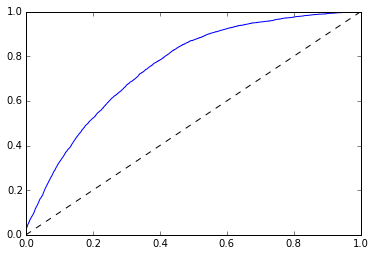

In [94]:
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)

from matplotlib import pyplot as plt
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1], 'k--');

### Ideas for improving the baseline model

* tuning the parameters of the model (we just used the default value of C=1.0)
* clustering of zip codes based on demographic data, and using the cluster id as an additional feature
* using the page url as well. To use the page directly will be probably too sparse, but we could extract many interesting features from the urls
* trying other machine learning algorithms and ensemble methods